### Challenge
At FakeFashionCorp, we're always looking to **improve our product recommendations for our customers**. As a member of our data science team, your task is to make the best recommendations possible based on the provided data:

- **Customer Search Data**: A list of google search queries made by a **specific** customer. You can find the data in the `./search_history.json` file.
- **Product Catalog**: A dataset containing 100,000 **fashion items** from our current inventory, including details such as product name, category, description, and other relevant attributes. You can find the data in the `./fashion_catalog.json` file.

Your challenge is to analyze the customer's search history and use this information to select the most relevant items from our product catalog that we should recommend to this customer.

Here are the specific requirements:

- Select the top items that best match the customer's apparent interests and preferences.
- Provide a brief explanation of your approach, including any assumptions you made and the reasoning behind your methodology.
- Include any visualizations or metrics that support your recommendations.
- Make sure to include the cell output in the final commit, we will **not** execute the script ourselves.
Hint: **how can we truly understand the customer's preferences?**
### Dummy approach
The following is what we consider a **dummy** approach. We expect you to find a more clever solution that this:
1. embed the customer's searches
2. rank the searches according to some semantic similarity to a fashion related anchor
3. for each fashion related search, find the product in the catalog that is most similar

We encourage you to be creative in your approach. There's no single correct solution, and we're interested in seeing how you tackle this real-world problem.

Hint: **how can we truly understand the customer's preferences?**

### Import Libraries

In [49]:
import json
import os
import datetime
import numpy as np
import pandas as pd
import string
import faiss
import matplotlib.pyplot as plt
from openai import OpenAI
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

scaler = MinMaxScaler(feature_range=(1, 2))
stop_words = list(ENGLISH_STOP_WORDS)
lemmatizer = WordNetLemmatizer()

In [4]:
client = OpenAI()

### Define functions

In [5]:
def clean_text(text:str) -> str:

    """
    Function to clean text, remove stopwords, and tokenizes words.

    Input:
    ________
        Text:str (Input text to clean)
    
    Output:
    ________
        Clean_text:str (Cleaned text)
    """

    if not isinstance(text, str) or not text:
        return np.nan
    tokens = [
        lemmatizer.lemmatize(word) for word in word_tokenize(text)
        if word not in string.punctuation and word not in stop_words
    ]
    return ' '.join(tokens)

In [6]:
def create_task(df:pd.DataFrame, prompt:str, df_row:str) -> list:

    """
    Creates batch tasks to be used in OpenAI batching API.

    Loops over each row of the given dataframe and structures it as a message using the prompt and text from that row.
    Uses gpt-4o-mini model.

    Input:
    ________
        df:pd.DataFrame (dataframe to convert to messages)
        prompt:str (user prompt to be used)
        df_row:str (dataframe row to be used for the user content)

    Output:
    ________
        tasks:list (List of tasks)
    
    """
    
    tasks = []
    for index, row in df.iterrows():
        task = {
            "custom_id":f"task-{index}",
            "method": "POST",
            "url": "/v1/chat/completions",
            "body": {
                "model": "gpt-4o-mini",
                "temperature": 0,
                "response_format": { 
                    "type": "json_object"
                },
                "messages": [
                    {
                        "role": "system",
                        "content": prompt
                    },
                    {
                        "role": "user",
                        "content": row[df_row]
                    }
                ],
            }
        }
        tasks.append(task)
    return tasks

In [7]:
def openai_batch(tasks:list, file_name:str, completion_window:str):

    """
    Creates a batch task by writing the a lists of tasks to a given file name then uploads to OpenAI.

    Input:
    ________
        tasks:list (list of tasks to be performed by OpenAI)
        file_name:str (name of the file)
        completion_window:str (timeframe to complete the job in)

    Output:
        batch_job (An OpenAI batch job element)

    """

    with open(file_name, 'w') as file:
        for obj in tasks:
            file.write(json.dumps(obj) + '\n')
    batch_file = client.files.create(
        file=open(file_name, "rb"),
        purpose="batch"
        )
    batch_job = client.batches.create(
        input_file_id=batch_file.id,
        endpoint="/v1/chat/completions",
        completion_window=completion_window
        )
    return batch_job

In [8]:
def write_batch_content(batch_job, file_name:str) -> list:

    """
    Write the content of a batch job to a given file name and loads it in as a list.

    Input:
    ________
        batch_job (An OpenAI batch job element).
        file_name:str (The name of the file)

    Output:
    ________
        results:list (The results from the batch job)
    """

    result_file_id = batch_job.output_file_id
    results = client.files.content(result_file_id).content

    with open(file_name, 'wb') as file:
        file.write(results)
    results = []
    with open(file_name, 'r') as file:
        for line in file:
            json_object = json.loads(line.strip())
            results.append(json_object)
    return results

In [9]:
def exact_brand_match(search_item:str, search_text:str) -> float:  

    """
    Check if the search brand exactly matches the catalog brand.

    Input:
    ________
        search_brand(str): Text to find.
        catalog_brand(str): Text to loook in.

    Output:
    ________
        match_score (float): Returns 1.0 if search itme is within the text.
    """
        
    return 1.0 if search_item in search_text else 0.0

### Load and Clean Data

In [10]:
# Load the JSON files and extract columns that will be used.
catalog_data = pd.read_json(r'/Users/ed/Documents/Python/OnFabric/onfabric-data-science-interview/fashion_catalog.json')
catalog_data = catalog_data[['GENDER', 'CATEGORY', 'SHORT_DESCRIPTION','LONG_DESCRIPTION']]
search_history = pd.read_json(r'/Users/ed/Documents/Python/OnFabric/onfabric-data-science-interview/search_history.json')
search_history = search_history[['title', 'time']]

In [11]:
# Apply text cleaning to the search_history dataframe.
# Filter results to only be ones that contain "Searched for", "Visited" but not "Visited https:" to remove noise from the dataset.
# Creates a IsVisited column if they visited the search title. The idea is that if the user clicks on a link they it shows greater intent
# of purchasing and therefore preference.

search_history['time'] = pd.to_datetime(search_history['time'], format='ISO8601')
search_history['title'] = search_history['title'].str.lower()
search_history = search_history[
    (search_history['title'].str.startswith('searched for') | search_history['title'].str.startswith('visited')) &
    ~search_history['title'].str.startswith('visited http')
]
search_history['IsVisited'] = search_history['title'].str.startswith('visited')
search_history['title'] = search_history['title'].str.replace(r'^(visited|searched for)\s+', '', regex=True)
search_history['title'] = search_history['title'].apply(lambda x: clean_text(x))
search_history.dropna(inplace=True)
search_history = search_history.reset_index()

In [12]:
# Clean the catalog data and create a full description column

catalog_data['SHORT_DESCRIPTION'] = catalog_data['SHORT_DESCRIPTION'].apply(lambda x: clean_text(x))
catalog_data['LONG_DESCRIPTION'] = catalog_data['LONG_DESCRIPTION'].apply(lambda x: clean_text(x))
catalog_data['full_description'] = catalog_data['SHORT_DESCRIPTION'] + " " + catalog_data['LONG_DESCRIPTION']

### Search History Data Exploration

In [68]:
# Define a system prompt and create tasks for further analysis of the search history dataset.
# The prompt is designed to extract additional information out of the data as well classifying if it's a fashion item or not.
# This allows us to reduce the dataset even further and adds additional insights into the data.

search_history_prompt = """Classify if the provided text refers to a fashion item. Respond in JSON format. Ensure the response includes:

1. "Fashion": Boolean, indicating whether the text is fashion-related ("True" or "False").
2. "Category": The specific type of fashion item (e.g., "Jeans", "Shoes", "Perfume"). Use "Unknown" if unclear.
3. "Brand": The brand name, if explicitly mentioned (e.g., "Nike", "Burberry"). Use "Unknown" if no brand is found.

Examples:
1. Text: "Nike Air Max Shoes"
   Response: {"Fashion":"True", "Category":"Shoes", "Brand":"Nike"}
2. Text: "Jamie Oliver"
   Response: {"Fashion":"False", "Category":"Unknown", "Brand":"Unknown"}
3. Text: "Adidas Sportswear"
   Response: {"Fashion":"True", "Category":"Sportswear", "Brand":"Adidas"}
"""

batch_file_name = '/Users/ed/Documents/Python/OnFabric/onfabric-data-science-interview/batch_search_history.jsonl'
search_history_tasks = create_task(search_history, search_history_prompt, 'title')
open_ai_batch_job = openai_batch(search_history_tasks, batch_file_name, '24h')

In [63]:
# Check on the status of the batch job from OpenAI.
# NB. Batching is cheaper than using the API directly so was chosen to reduce costs. 
# for more time sensitive projects the API should be used if using OpenAI.
# NB 2. This code only works with manual execution and a time delay, can only move onto next step when status = "Completed", 
# could easily put a automatic check in a full script.

batch_job = client.batches.retrieve(open_ai_batch_job.id)
batch_job.status

'completed'

In [64]:
# Retrive the content from the batch job and load it into a list.
result_file_name = "search_history_results.jsonl"
results = write_batch_content(batch_job, result_file_name)

In [66]:
# Extract the message content from the results list and create a dataframe of the information.

data = []
for result in results:
    task_id = result['custom_id']
    index = task_id.split('-')[-1]
    response = json.loads(result['response']['body']['choices'][0]['message']['content'])
    is_fashion = response['Fashion']
    try:
        category = response['Category']
    except KeyError:
        category = 'Unknown'
    try:
        brand = response['Brand']
    except KeyError:
        brand = 'Unknown'
    data.append({
        "index": int(index),
        "IsFashion": is_fashion,
        "Category":category,
        "Brand":brand,
    })

results_df = pd.DataFrame(data)

In [78]:
# Merge the OpenAI results with the search history.
# Write the results to Excel for a manual validation phase.

fashion_search_history = pd.merge(results_df, search_history, left_on='index', right_index=True)
fashion_search_history['time'] = pd.to_datetime(fashion_search_history['time']).dt.tz_localize(None)
fashion_search_history.to_excel('OpenAIResults.xlsx', index=True)

# Example of the results:
# NB. Some refinement of the prompts are required to filter out some more results.
fashion_search_history[fashion_search_history['IsFashion'] == 'True'].sample(10)

,index,index_x,IsFashion,Category,Brand,index_y,title,time,IsVisited
7932,7932,7932,True,Jewellery,Tiffany,9532,luxury birthday gift jewellery tiffany,2023-03-31 15:20:43.607,True
10359,10359,10359,True,Sweater,Unknown,12407,short sweater,2022-11-20 21:19:55.380,False
22900,22900,22900,True,Shoes,New Look,28570,new look europe 38 shoe,2021-08-06 13:31:46.051,False
36098,36098,36098,True,Dress,Unknown,46633,double breasted long sleeve dress,2018-09-22 16:21:53.127,False
11031,11031,11031,True,Jacket,Hobbs,13220,hobbs blue short jacket,2022-10-26 21:18:55.740,False
24236,24236,24236,True,Scrubs,Grey's Anatomy,30295,breathe grey 's anatomy,2021-06-12 12:40:29.330,False
41722,41722,41722,True,Fragrance,Victoria's Secret,55021,intense victoria 's secret woman fragrantica,2017-08-27 07:36:10.048,True
31723,31723,31723,True,Bag,Unknown,40498,chic designer bag,2020-02-22 13:50:23.849,False
6233,6233,6233,True,Luggage,Brics,7411,brics suitcase,2023-07-08 14:23:35.580,False
36516,36516,36516,True,Dress,Unknown,47324,kate middleton dress,2018-08-19 09:06:14.428,False


In [96]:
# Filter the to only fashion items. 
fashion_search_history = fashion_search_history[fashion_search_history['IsFashion'] == 'True']

### Embedding

In [97]:
# Embed the title from the search history and short_description from the catalog.
# NB. Potentially missing information from the long_description but due to time only short_description 
# is going to be used to match to the title. Also most likely that a human searches at a "higher" level therefore short description should
# provide reasonable results.
# NB2. Explore other embedding models to see how results can be improved.
# NB3. Explore different batch sizes/pooling?

embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
fashion_search_history['title_embedding'] = fashion_search_history['title'].apply(lambda x: embedding_model.encode(x, batch_size=64))
#catalog_data['short_embedding'] = catalog_data['SHORT_DESCRIPTION'].apply(lambda x: embedding_model.encode(x, batch_size=64))

/var/folders/y1/cblk02913sv7z90f1y17flr40000gn/T/ipykernel_55626/2863647582.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fashion_search_history['title_embedding'] = fashion_search_history['title'].apply(lambda x: embedding_model.encode(x, batch_size=64))


In [99]:
catalog_embeddings = np.vstack(catalog_data['short_embedding'].values).astype('float32')
search_embeddings = np.vstack(fashion_search_history['title_embedding'].values).astype('float32')

### Weighting

In [ ]:
### Apply weights to each search item.
# Use a decay on time, this reduces the impact of older searches to ensure recommendations are up to date
# Add a multiplier if they clicked on the link vs just searching it. As previously mentioned visiting a link shows greater intent.
# Use clustering (DBSCAN) to group the searches into similar items. 

# NB. eps on DBSCAN should have some statistical backing, e.g. silthouse.

In [100]:
# Set weighting parameters.
# NB. These should have some statistical backing.

decay_rate = 0.01
visit_multiplier = 1.1
frequency_multiplier = 1.2
brand_frequency_multiplier = 1.05

In [101]:
# Ensure time is in the correct format
fashion_search_history['time'] = pd.to_datetime(fashion_search_history['time'], utc=True)

/var/folders/y1/cblk02913sv7z90f1y17flr40000gn/T/ipykernel_55626/119989424.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fashion_search_history['time'] = pd.to_datetime(fashion_search_history['time'], utc=True)


In [102]:
# Clustering
clustering = DBSCAN(eps=0.2, min_samples=1, metric='cosine').fit(search_embeddings)
fashion_search_history['cluster'] = clustering.labels_

current_time = datetime.datetime.now(datetime.timezone.utc)

# Title Weight
fashion_search_history['recency_weight'] = np.exp(-decay_rate * (current_time - fashion_search_history['time']).dt.total_seconds() / (60 * 60 * 24))
fashion_search_history['visit_weight'] = np.where(fashion_search_history['IsVisited'] == 1, visit_multiplier, 1)
fashion_search_history['frequency'] = fashion_search_history.groupby('cluster')['cluster'].transform('count')
fashion_search_history['frequency_weight'] = frequency_multiplier ** (fashion_search_history['frequency'] - 1)
fashion_search_history['title_weight'] = fashion_search_history['recency_weight'] * fashion_search_history['visit_weight'] * fashion_search_history['frequency_weight']

# Brand frequency weight
fashion_search_history['brand_frequency'] = fashion_search_history.groupby('Brand')['Brand'].transform('count')
fashion_search_history['brand_weight'] = np.where(
    fashion_search_history['Brand'] == "Unknown", 1,brand_frequency_multiplier ** (fashion_search_history['brand_frequency'] - 1))

# Normalise weight columns
fashion_search_history['title_weight'] = scaler.fit_transform(fashion_search_history[['title_weight']])
fashion_search_history['brand_weight'] = scaler.fit_transform(fashion_search_history[['brand_weight']])

/var/folders/y1/cblk02913sv7z90f1y17flr40000gn/T/ipykernel_55626/2570650888.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fashion_search_history['cluster'] = clustering.labels_
/var/folders/y1/cblk02913sv7z90f1y17flr40000gn/T/ipykernel_55626/2570650888.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fashion_search_history['recency_weight'] = np.exp(-decay_rate * (current_time - fashion_search_history['time']).dt.total_seconds() / (60 * 60 * 24))
/var/folders/y1/cblk02913sv7z90f1y17flr40000gn/T/ipy

In [104]:
# Export to Excel to manually check weightings in more detail
fashion_search_history_copy = fashion_search_history.copy()
fashion_search_history_copy['time'] = fashion_search_history_copy['time'].dt.tz_localize(None)
fashion_search_history_copy.to_excel(r'WeightingResults.xlsx', index=False)

# Example:
fashion_search_history.sample(10)

,index,index_x,IsFashion,Category,Brand,index_y,title,time,IsVisited,title_embedding,cluster,recency_weight,visit_weight,frequency,frequency_weight,title_weight,brand_frequency,brand_weight
35751,35751,35751,True,Turtleneck,Unknown,46055,fitted black turtleneck,2018-11-22 22:03:21.829000+00:00,False,"[-0.065730475, 0.121270955, 0.021475554, 0.050...",989,3.246825e-10,1.0,1,1.000000,1.000000,761,1.000000
21113,21113,21113,True,Jacket,Burberry,26205,burberry quilted jacket,2021-10-15 09:08:59.715000+00:00,False,"[-0.053502943, 0.11530983, -0.029852344, 0.031...",408,1.270454e-05,1.0,13,8.916100,1.000039,32,2.000000
8292,8292,8292,True,Unknown,Maggie,9963,maggie 's kensington,2023-03-14 16:16:25.215000+00:00,False,"[0.012892066, -0.09371085, 0.04966026, -0.0187...",293,2.197175e-03,1.0,2,1.200000,1.000913,2,1.014132
30281,30281,30281,True,Jewellery,Beaf,38536,beaf casual jewellery brand uk,2020-07-20 18:07:00.507000+00:00,False,"[0.0064797727, -0.04939625, -0.028069701, -0.0...",815,1.388579e-07,1.0,2,1.200000,1.000000,1,1.000000
8166,8166,8166,True,Pantsuit,Unknown,9815,best woman 's pant suit,2023-03-20 21:45:51.123000+00:00,False,"[-0.037241902, 0.06633371, 0.023219384, -0.051...",286,2.338385e-03,1.0,1,1.000000,1.000810,761,1.000000
16509,16509,16509,True,Jewellery,Unknown,20125,outhouse jewellery shop designer jewellery online,2022-04-02 07:41:24.623000+00:00,True,"[-0.042060513, 0.034053072, -0.030437166, 0.03...",522,6.881016e-05,1.1,4,1.728000,1.000045,761,1.000000
13832,13832,13832,True,Helmet,Triple 8,16768,triple 8 mips helmet,2022-07-02 12:37:29.932000+00:00,False,"[-0.07305177, 0.101860836, 0.039452303, -0.053...",485,1.712985e-04,1.0,1,1.000000,1.000059,2,1.014132
33124,33124,33124,True,Makeup Primer,Benefit,42485,benefit porefessional value size primer house ...,2019-09-30 06:37:23.849000+00:00,True,"[0.0546947, 0.04219686, -0.016085573, -0.01295...",908,7.305753e-09,1.1,1,1.000000,1.000000,1,1.000000
18967,18967,18967,True,Shoes,Unknown,23398,shoe sale luxury,2021-12-31 09:35:11.019000+00:00,False,"[-0.038150933, 0.021487428, 0.018954717, -0.00...",612,2.744383e-05,1.0,9,4.299817,1.000041,761,1.000000
11611,11611,11611,True,Unknown,Burberry,13941,burberry,2022-10-03 18:29:54.705000+00:00,False,"[0.002287802, 0.049861215, -0.07962695, -0.003...",94,4.352214e-04,1.0,12,7.430084,1.001120,32,2.000000


### Match and Rank the searches to the catalog

In [87]:
# Use faiss to match the searches to the short_description in the catalog with cosine similarity.
# Use a basic string match to match the brand. As the brand is generated by OpenAI and written in the catalog the 
# spelling is likely to be correct. Although, it's highly likely that a fuzzy match or even embedding would provide improved results.

In [105]:
# Define weights and thresholds.
# NB. These should be optimized.
title_similarity_weight = 0.9
brand_similarity_weight = 0.1

similarity_threshold = 0.7
top_k = 5

In [106]:
# Set up faiss
index = faiss.IndexFlatIP(catalog_embeddings.shape[1])
faiss.normalize_L2(catalog_embeddings)
index.add(catalog_embeddings)

faiss.normalize_L2(search_embeddings)
_, indices = index.search(search_embeddings, top_k)

# Apply matching and create an output result with all relevant information in.
recommendations = []
for search_idx, catalog_indices in enumerate(indices):
    search_row = fashion_search_history.iloc[search_idx]
    search_brand = search_row['Brand']
    title_weight = search_row['title_weight']
    brand_weight = search_row['brand_weight']
    
    for catalog_idx in catalog_indices:
        catalog_row = catalog_data.iloc[catalog_idx]        
        title_similarity = cosine_similarity(
            [search_row['title_embedding']],
            [catalog_row['short_embedding']]
        )[0, 0]
        if title_similarity < similarity_threshold:  # Skip if below threshold 
            continue
        
        brand_similarity = exact_brand_match(search_brand, catalog_row['full_description'])
        
        weighted_similarity = (
            title_similarity_weight * title_similarity * title_weight +
            brand_similarity_weight * brand_similarity * brand_weight
        )

        recommendations.append({
            "Catalog_ID": catalog_idx,
            "Category": catalog_row['CATEGORY'],
            "Catalog_Short_Description": catalog_row['SHORT_DESCRIPTION'],
            "Catalog_Long_Description": catalog_row['LONG_DESCRIPTION'],
            "Search_Title": search_row['title'],
            "Title_Similarity": title_similarity,
            "Brand_Match": brand_similarity,
            "Total_Weight": weighted_similarity,
        })

In [107]:
recommendations

[{'Catalog_ID': np.int64(19549),
  'Category': 'sandals',
  'Catalog_Short_Description': 'Oasis Sandal',
  'Catalog_Long_Description': 'In 1984 brother South America founded Reef love beach surfing Their idea create comfortable high-quality product fit lifestyle adored Their attention uncompromising standard quality mean started Reef sandal evolved iconic sandal seen today The latest arrival Reef Oasis Sandal Please carefully read washing instruction Sandal best possible condition Click Reef collection',
  'Search_Title': 'hermes oasis sandal',
  'Title_Similarity': np.float32(0.831954),
  'Brand_Match': 0.0,
  'Total_Weight': np.float64(0.816941969313941)},
 {'Catalog_ID': np.int64(81385),
  'Category': 'flats',
  'Catalog_Short_Description': 'London Sandal',
  'Catalog_Long_Description': "The London sandal White Mountain great day wear This silhouette fashioned cushioned footbed easily pair playful dress jean basic tee versatile look Faux leather upper Slingack strap adjustable buckl

In [112]:
# Group up the highest scoring catalog items and their related search items ready for investigation.

recommendations_df = pd.DataFrame(recommendations)

# Remove the filtering for the top 20 catalog items
recommendations_df['Total_Similar_Results'] = recommendations_df.groupby("Catalog_ID")['Catalog_ID'].transform('count')
output_df = recommendations_df.sort_values(by=["Catalog_ID", "Total_Weight"], ascending=[True, False])
output_df = output_df[[
    "Catalog_ID",
    "Category",
    "Catalog_Short_Description",
    "Catalog_Long_Description",
    "Total_Similar_Results",
    "Search_Title",
    "Total_Weight",
    "Title_Similarity",
    "Brand_Match"
]]

# Display the full DataFrame
output_df

,Catalog_ID,Category,Catalog_Short_Description,Catalog_Long_Description,Total_Similar_Results,Search_Title,Total_Weight,Title_Similarity,Brand_Match
1241,32,clutches,Handbag,Medium leather brand logo solid colour fully l...,3,classic handbag,0.803614,0.892904,0.0
1246,32,clutches,Handbag,Medium leather brand logo solid colour fully l...,3,best designer handbag work,0.673500,0.748333,0.0
852,32,clutches,Handbag,Medium leather brand logo solid colour fully l...,3,luxury handbag sale,0.636544,0.707264,0.0
958,67,sneakers,Trainers,Leather suede effect brand logo multicolour pa...,3,heeled trainer,0.664711,0.738566,0.0
1107,67,sneakers,Trainers,Leather suede effect brand logo multicolour pa...,3,heeled trainer,0.664709,0.738566,0.0
...,...,...,...,...,...,...,...,...,...
1374,99012,sneakers,Monaco2,Low-Top Leather Sneakers,1,pal monaco,0.709682,0.788535,0.0
232,99044,t-shirts,Club Tennis T-shirt,Men 's tennis tee ease movement REGULAR FIT Wi...,1,nike court tennis dress,0.646780,0.716969,0.0
554,99095,lingerie,X Jacquemus Bra,Out world Nike x Jacquemus latest collection s...,1,jacquemus,0.762672,0.729306,1.0
1769,99841,heels,Chain Leather Pump,Please note Size selection European For US con...,1,tommy hilfiger colour blocked leather pump,0.641157,0.712397,0.0


In [113]:
# Write the output to Excel for further analysis of the results
output_df.to_excel(r'FinalOutput.xlsx', index=False)

In [7]:
# Visual display of the highest searched categories and brands

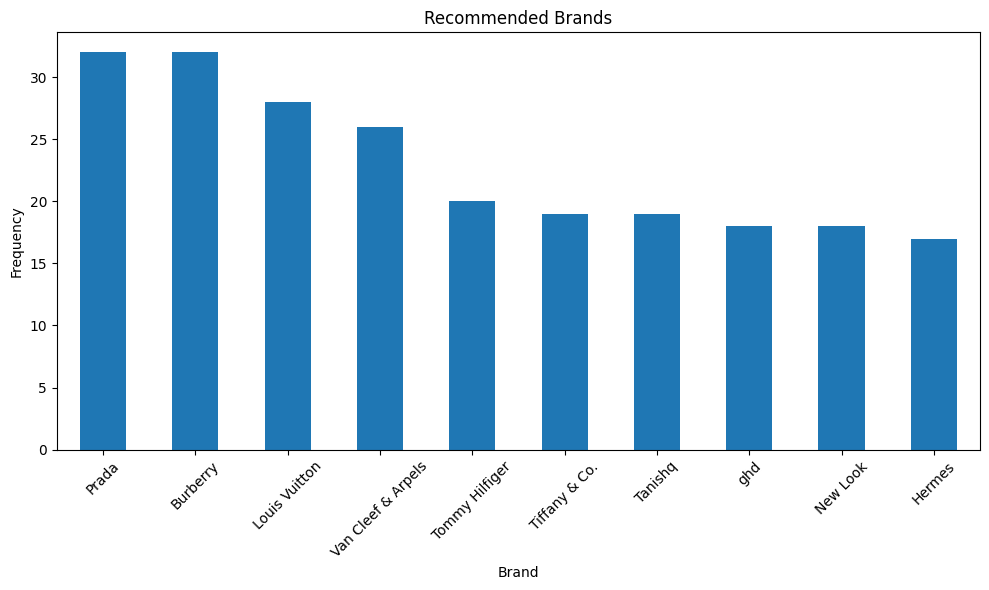

In [114]:
brand_counts = fashion_search_history[fashion_search_history['Brand'] != 'Unknown']['Brand'].value_counts()

# Select the top 10 brands
top_10_brands = brand_counts.head(10)

# Plot the top 10 brands
plt.figure(figsize=(10, 6))
top_10_brands.plot(kind='bar')
plt.title('Recommended Brands')
plt.xlabel('Brand')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

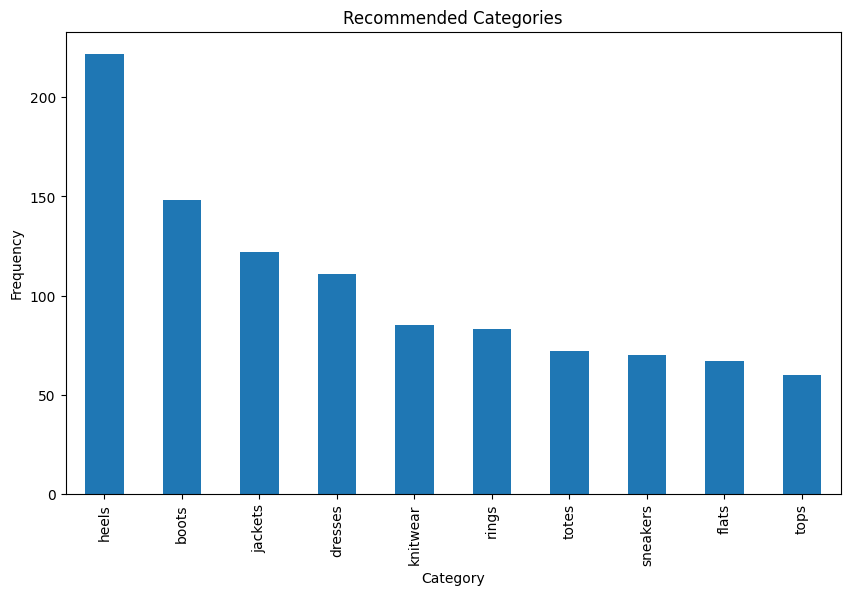

In [115]:
top_categories = output_df['Category'].value_counts().nlargest(10)
plt.figure(figsize=(10, 6))
top_categories.plot(kind='bar')
plt.title('Recommended Categories')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()

### Future work

#### General Comments

- Move the code into python scripts with a more modular set up.
- Add detailed logging into the code.
- Add more error handling into the code.
- Explore other customer data and try to create "user groups". This may allow for some prediction based recommendation model rather than just historical.

#### Model enhancements
- Explore seasonality
- Expand the system prompt to extract more detail, e.g. color, type (Casual, Formal, Sportswear etc..). Apply the same logic to the catalog, this creates more elements to link on potentially gaining greater knowledge preferences.
- Explore different embedding models and chat based models.

These are a few ideas that would be interesting to explore to try to improve the recommendation engine.